<a href="https://colab.research.google.com/github/eaderogba/MP_Detection_ML/blob/main/Malaria_Detection_Demo_TF(with%20Model%20Test).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, Sequential
import os

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/Dataset/Train'
test_path = '/content/drive/MyDrive/Colab Notebooks/Test_Model'

In [ ]:
batch_size = 32
img_height = 128
img_width = 128

In [65]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    class_names=['infected', 'uninfected'],
)

Found 1598 files belonging to 2 classes.
Using 1279 files for training.


In [71]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary')

Found 1598 files belonging to 2 classes.
Using 319 files for validation.


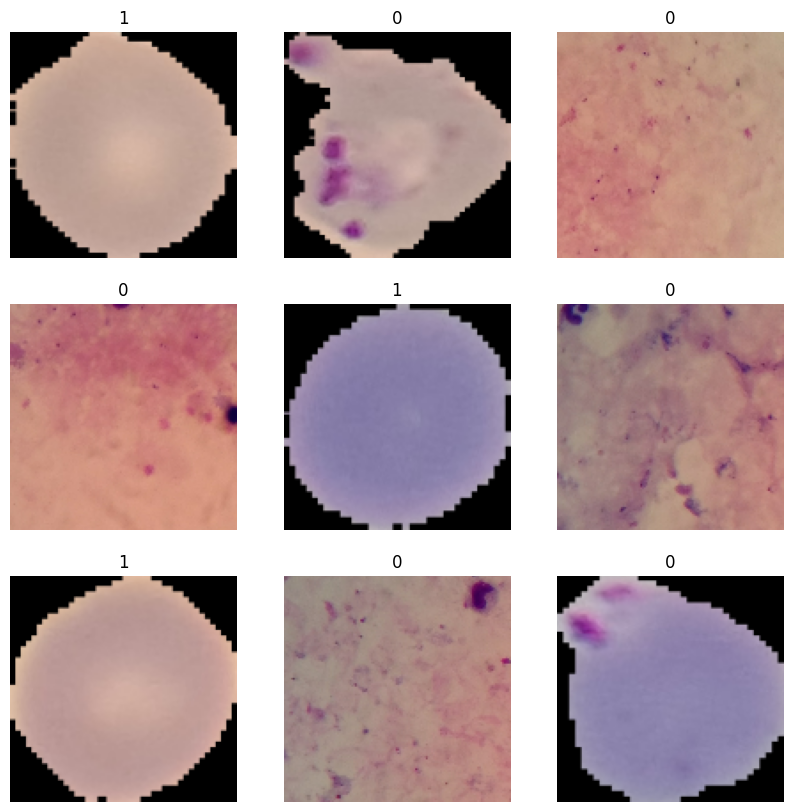

In [72]:
# Visualise the Training Dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

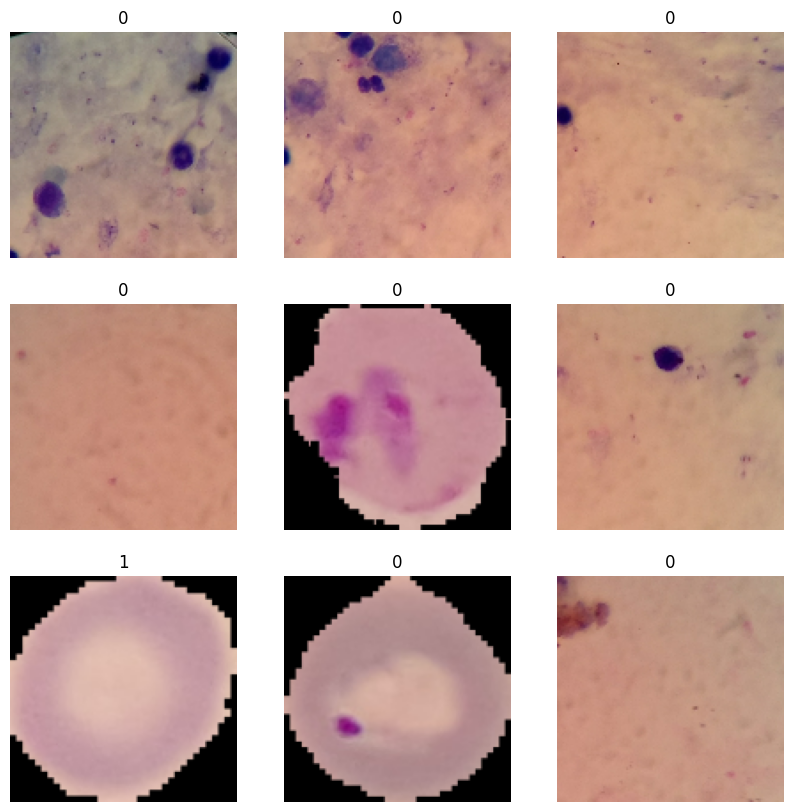

In [75]:
# Visualise the Validation Dataset
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [76]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32, 1)


In [77]:
#Standardise the data
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [78]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [79]:
# Train Model
num_classes = 2

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [80]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [83]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
40/40 [==============================] - 1s 21ms/step - loss: 0.1090 - accuracy: 0.9515 - val_loss: 0.0883 - val_accuracy: 0.9561
Epoch 2/10
40/40 [==============================] - 1s 18ms/step - loss: 0.1033 - accuracy: 0.9578 - val_loss: 0.0875 - val_accuracy: 0.9592
Epoch 3/10
40/40 [==============================] - 1s 18ms/step - loss: 0.0940 - accuracy: 0.9601 - val_loss: 0.0751 - val_accuracy: 0.9624
Epoch 4/10
40/40 [==============================] - 1s 18ms/step - loss: 0.0867 - accuracy: 0.9664 - val_loss: 0.0437 - val_accuracy: 0.9875
Epoch 5/10
40/40 [==============================] - 1s 18ms/step - loss: 0.0810 - accuracy: 0.9703 - val_loss: 0.0841 - val_accuracy: 0.9718
Epoch 6/10
40/40 [==============================] - 1s 17ms/step - loss: 0.0992 - accuracy: 0.9609 - val_loss: 0.0573 - val_accuracy: 0.9749
Epoch 7/10
40/40 [==============================] - 1s 18ms/step - loss: 0.0586 - accuracy: 0.9812 - val_loss: 0.0320 - val_accuracy: 0.9937
Epoch 8/10
40

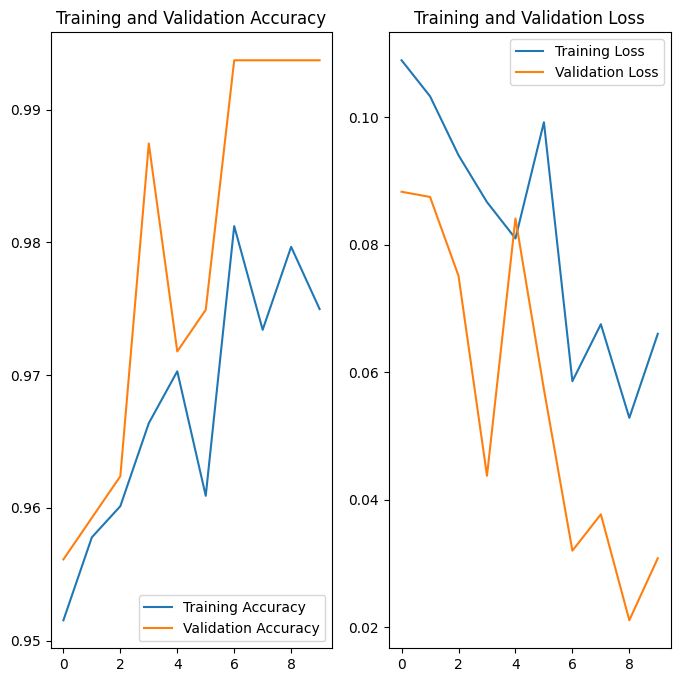

In [84]:
# Visualise training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [90]:
# List files in the directory
image_files = [f for f in os.listdir(test_path) if os.path.isfile(os.path.join(test_path, f))]

# Class names
class_names=['infected', 'uninfected']

for img_file in image_files:
  # Image path
  img_path = os.path.join(test_path, img_file)

  # Load and process images
  img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
  img_array = tf.keras.utils.img_to_array(img)
  img_array = tf.expand_dims(img_array, 0) # Create a batch

  # Predict on New Data
  predictions = model.predict(img_array)
  score = tf.nn.softmax(predictions[0])

  print(
      "This image most likely belongs to {} with a {:.2f} percent confidence."
      .format(class_names[np.argmax(score)], 100 * np.max(score))
  )

1/1 [==============================] - 0s 18ms/step
This image most likely belongs to uninfected with a 94.70 percent confidence.
1/1 [==============================] - 0s 50ms/step
This image most likely belongs to uninfected with a 70.95 percent confidence.
1/1 [==============================] - 0s 20ms/step
This image most likely belongs to uninfected with a 92.51 percent confidence.
1/1 [==============================] - 0s 19ms/step
This image most likely belongs to infected with a 99.52 percent confidence.
1/1 [==============================] - 0s 17ms/step
This image most likely belongs to uninfected with a 86.38 percent confidence.
1/1 [==============================] - 0s 17ms/step
This image most likely belongs to infected with a 57.15 percent confidence.
1/1 [==============================] - 0s 18ms/step
This image most likely belongs to uninfected with a 76.55 percent confidence.
1/1 [==============================] - 0s 16ms/step
This image most likely belongs to uninfect